# Explore the National-Scale Environmental Pressure Indicators Dataset

## Introduction
This notebook provides an exploratory data analysis (EDA) of the "National-Scale Environmental Pressure Indicators from 1990 to 2050" dataset. This dataset contains historical (1990–2020) and forecasted (2021–2050) national-level data for key environmental and socioeconomic indicators, including Municipal Solid Waste (MSW) generation, greenhouse gas emissions (CO₂, CH₄, N₂O), GDP per capita (PPP), and population for 43 countries.

Learn more:
- Data Package doi: [10.71728/senscience.k2f7-p5v9](https://doi.org/10.71728/senscience.k2f7-p5v9)

This notebook will guide you through loading, exploring, and visualizing the data to uncover key trends and insights.

### Install and import required libraries

In [ ]:
# Install mlcroissant from the source
!sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config
!pip install mlcroissant[dev]

In [1]:
from mlcroissant import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### Load and Preprocess the Data
We will now use `mlcroissant` and the `fair2.json` metadata file to load the historical and forecast data from their respective record sets.

In [ ]:
# Load the dataset using mlcroissant and the fair2.json metadata file
ds = Dataset(jsonld='https://sen.science/doi/10.71728/senscience.k2f7-p5v9/fair2.json')

# Load historical and forecast records as DataFrames
historical_records = ds.records('https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Historical')
forecast_records = ds.records('https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Forecast')


# 1. Clean up byte strings in both DataFrames and ensure numeric columns are read as numbers
def decode_bytes(val):
    if isinstance(val, bytes):
        return val.decode('utf-8')
    return val

historical_df = pd.DataFrame(historical_records)
forecast_df = pd.DataFrame(forecast_records)

historical_df = historical_df.applymap(decode_bytes)
forecast_df = forecast_df.applymap(decode_bytes)

# Convert columns that should be numeric to numbers (before renaming, use original column names)
numeric_cols_hist = ['Year', 'Population', 'GDPcapitaPPPcurrentinternational$', 'MSWgenerationtyear',
                     'CO2emissionstCO2-eqyear', 'CH4emissionstCO2-eqyear', 'N2OemissionstCO2-eqyear']
numeric_cols_fore = ['Year', 'Population', 'GDPcapitaPPPcurrentinternational$', 'MSWgenerationtyear',
                     'CO2emissionstCO2-eqyear', 'CH4emissionstCO2-eqyear', 'N2OemissionstCO2-eqyear']

for col in numeric_cols_hist:
    if col in historical_df.columns:
        historical_df[col] = pd.to_numeric(historical_df[col], errors='coerce')
for col in numeric_cols_fore:
    if col in forecast_df.columns:
        forecast_df[col] = pd.to_numeric(forecast_df[col], errors='coerce')

# 2. Rename columns to standard names using the provided mapping
common_columns_rename = {
    'https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Historical/fields/CountryRegionName': 'Country',
    'https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Historical/fields/Year': 'Year',
    'https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Historical/fields/Population': 'Population',
    'https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Historical/fields/GDPcapitaPPPcurrentinternational$': 'GDP_per_capita',
    'https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Historical/fields/MSWgenerationtyear': 'MSW_generation',
    'https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Historical/fields/CO2emissionstCO2-eqyear': 'CO2_emissions',
    'https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Historical/fields/CH4emissionstCO2-eqyear': 'CH4_emissions',
    'https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Historical/fields/N2OemissionstCO2-eqyear': 'N2O_emissions',
    'https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Forecast/fields/CountryRegionName': 'Country',
    'https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Forecast/fields/Year': 'Year',
    'https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Forecast/fields/Population': 'Population',
    'https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Forecast/fields/GDPcapitaPPPcurrentinternational$': 'GDP_per_capita',
    'https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Forecast/fields/MSWgenerationtyear': 'MSW_generation',
    'https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Forecast/fields/CO2emissionstCO2-eqyear': 'CO2_emissions',
    'https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Forecast/fields/CH4emissionstCO2-eqyear': 'CH4_emissions',
    'https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Forecast/fields/N2OemissionstCO2-eqyear': 'N2O_emissions',
    'https://sen.science/doi/10.71728/senscience.k2f7-p5v9/recordsets/Forecast/fields/CH4emissionstCO2-weyear': 'CH4_emissions_we'
}
historical_df = historical_df.rename(columns=common_columns_rename)
forecast_df = forecast_df.rename(columns=common_columns_rename)

# 3. For forecast_df, split 'Year' if it contains scenario info (e.g., 'SSP1_2021')
if forecast_df['Year'].astype(str).str.contains('_', na=False).any():
    mask = forecast_df['Year'].astype(str).str.contains('_', na=False)
    scenario_year = forecast_df.loc[mask, 'Year'].astype(str).str.split('_', expand=True, n=1)
    forecast_df.loc[mask, 'Scenario'] = scenario_year[0]
    forecast_df.loc[mask, 'Year'] = scenario_year[1]
else:
    forecast_df['Scenario'] = np.nan

# 4. Convert numeric columns to appropriate types
for col in ['Year', 'Population', 'GDP_per_capita', 'MSW_generation', 'CO2_emissions', 'CH4_emissions', 'N2O_emissions']:
    if col in historical_df.columns:
        historical_df[col] = pd.to_numeric(historical_df[col], errors='coerce')
    if col in forecast_df.columns:
        forecast_df[col] = pd.to_numeric(forecast_df[col], errors='coerce')

# 5. Drop extra column in forecast_df if present
if 'CH4_emissions_we' in forecast_df.columns:
    forecast_df = forecast_df.drop(columns=['CH4_emissions_we'])

print("Preprocessing complete. DataFrames are ready for analysis.")

  -  [Metadata(National-Scale Environmental Pressure Indicators from 1990 to 2050: A Dataset for Emissions, Waste, and Socioeconomic Drivers)] Property "https://schema.org/version" is recommended, but does not exist.


Preprocessing complete. DataFrames are ready for analysis.


/var/folders/sr/rb0fdyrd6mj5vn4v5zcgw8vm0000gp/T/ipykernel_18134/4047612580.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  historical_df = historical_df.applymap(decode_bytes)
/var/folders/sr/rb0fdyrd6mj5vn4v5zcgw8vm0000gp/T/ipykernel_18134/4047612580.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  forecast_df = forecast_df.applymap(decode_bytes)


### Explore the Datasets

Now, let's take a first look at the loaded dataframes to understand their structure, columns, and content.

In [3]:
print("Historical Data Head:")
display(historical_df.head())

print("\nForecast Data Head:")
display(forecast_df.head())

Historical Data Head:


,Country,Year,Population,GDP_per_capita,MSW_generation,CO2_emissions,CH4_emissions,N2O_emissions
0,Algeria,1990,25758872,6912.087141,6293602.897,279093.7905,3262204.229,35910.85209
1,Algeria,1991,26400468,6888.509950,7562686.980,335372.1248,3397646.844,43152.15593
2,Algeria,1992,27028330,7005.700763,6989796.547,309966.9371,3590497.254,39883.28372
3,Algeria,1993,27635517,6866.889117,7417683.078,328941.8353,3723096.982,42324.77394
4,Algeria,1994,28213777,6807.951662,7434268.428,329677.3231,3867265.309,42419.40877



Forecast Data Head:


,Country,Year,Population,GDP_per_capita,MSW_generation,CO2_emissions,CH4_emissions,N2O_emissions,Scenario
0,Algeria,1990,25758872.0,6912.087141,6293602.897,279093.7905,3262204.229,35910.85209,NaN
1,Algeria,1991,26400468.0,6888.509950,7562686.980,335372.1248,3397646.844,43152.15593,NaN
2,Algeria,1992,27028330.0,7005.700763,6989796.547,309966.9371,3590497.254,39883.28372,NaN
3,Algeria,1993,27635517.0,6866.889117,7417683.078,328941.8353,3723096.982,42324.77394,NaN
4,Algeria,1994,28213777.0,6807.951662,7434268.428,329677.3231,3867265.309,42419.40877,NaN


In [4]:
print("Historical Data Head:")
display(historical_df.tail())

print("\nForecast Data Head:")
display(forecast_df.tail())

Historical Data Head:


,Country,Year,Population,GDP_per_capita,MSW_generation,CO2_emissions,CH4_emissions,N2O_emissions
1328,Vietnam,2016,93640435,6572.976234,12105955.00,1489537.464,2873376.667,123155.9399
1329,Vietnam,2017,94600643,7155.443187,11741831.75,1444735.115,2955601.468,119451.6522
1330,Vietnam,2018,95545959,7768.080218,12242312.77,1506315.158,3034774.193,124543.1307
1331,Vietnam,2019,96462108,8381.239320,12532537.22,1542024.871,3118851.251,127495.6334
1332,Vietnam,2020,97338583,8650.133470,13300987.97,1636576.369,3217637.735,135313.2136



Forecast Data Head:


,Country,Year,Population,GDP_per_capita,MSW_generation,CO2_emissions,CH4_emissions,N2O_emissions,Scenario
7778,Vietnam,2050,1.001332e+08,37399.85090,24400000.0,1626609.546,3752542.968,252515.1015,SSP1
7779,Vietnam,2050,1.053830e+08,27172.98653,22600000.0,1603595.961,3745715.156,255930.5575,SSP2
7780,Vietnam,2050,1.124259e+08,19889.33105,21300000.0,1580953.549,3738685.048,259184.7870,SSP3
7781,Vietnam,2050,9.886068e+07,27811.04572,21400000.0,1558763.892,3731475.644,262286.6151,SSP4
7782,Vietnam,2050,9.877513e+07,46961.30748,26300000.0,1537098.319,3724108.370,265244.0610,SSP5


In [5]:
print("Historical Data Info:")
historical_df.info()

print("\nForecast Data Info:")
forecast_df.info()

Historical Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1333 entries, 0 to 1332
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         1333 non-null   object 
 1   Year            1333 non-null   int64  
 2   Population      1333 non-null   int64  
 3   GDP_per_capita  1333 non-null   float64
 4   MSW_generation  1333 non-null   float64
 5   CO2_emissions   1333 non-null   float64
 6   CH4_emissions   1333 non-null   float64
 7   N2O_emissions   1333 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 83.4+ KB

Forecast Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7783 entries, 0 to 7782
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         7783 non-null   object 
 1   Year            7783 non-null   int64  
 2   Population      7783 non-null   float64
 3   GD

In [6]:
print("Historical Data Summary Statistics:")
display(historical_df.describe())

Historical Data Summary Statistics:


,Year,Population,GDP_per_capita,MSW_generation,CO2_emissions,CH4_emissions,N2O_emissions
count,1333.000000,1.333000e+03,1333.000000,1.333000e+03,1.333000e+03,1.333000e+03,1.333000e+03
mean,2005.000000,1.272527e+08,15998.800541,3.183428e+07,6.847251e+06,1.117001e+07,2.373768e+05
std,8.947629,2.499312e+08,14369.549851,4.768361e+07,1.475613e+07,1.540790e+07,4.328485e+05
min,1990.000000,1.495151e+07,346.362657,1.938061e+06,1.881391e+03,5.778157e+05,5.472718e+01
25%,1997.000000,3.362890e+07,4811.260418,9.113685e+06,7.815298e+05,3.468216e+06,4.449236e+04
50%,2005.000000,5.768533e+07,11148.196550,1.551588e+07,1.982287e+06,6.409463e+06,8.572534e+04
75%,2013.000000,1.030810e+08,24085.324180,3.100217e+07,5.113261e+06,1.168389e+07,2.132058e+05
max,2020.000000,1.410929e+09,65279.529030,2.857224e+08,9.456730e+07,9.151364e+07,3.287769e+06


## Data Visualization

Visualizing the data can help us understand trends, patterns, and relationships between different variables.

### Choropleth Map of Latest Municipal Solid Waste (MSW) Generation
This map shows the most recent MSW generation data available in the historical dataset for each country. We use a logarithmic scale to better visualize the wide range of values.

In [7]:
# Prepare latest_year_df: for each country, get the row with the latest year
latest_year_idx = historical_df.groupby('Country')['Year'].idxmax()
latest_year_df = historical_df.loc[latest_year_idx].reset_index(drop=True)

fig = px.choropleth(latest_year_df,
                    locations="Country",
                    locationmode='country names',
                    color="MSW_generation",
                    hover_name="Country",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Latest MSW Generation by Country (Historical Data)",
                    labels={'MSW_generation':'MSW Generation (tons/year)'})


fig.show()

### Trends in MSW Generation for Key Countries

Let's examine the historical and projected trends in MSW generation for a selection of countries. For the forecast, we'll use the **SSP2 (Middle of the Road)** scenario, which represents a future following historical patterns.

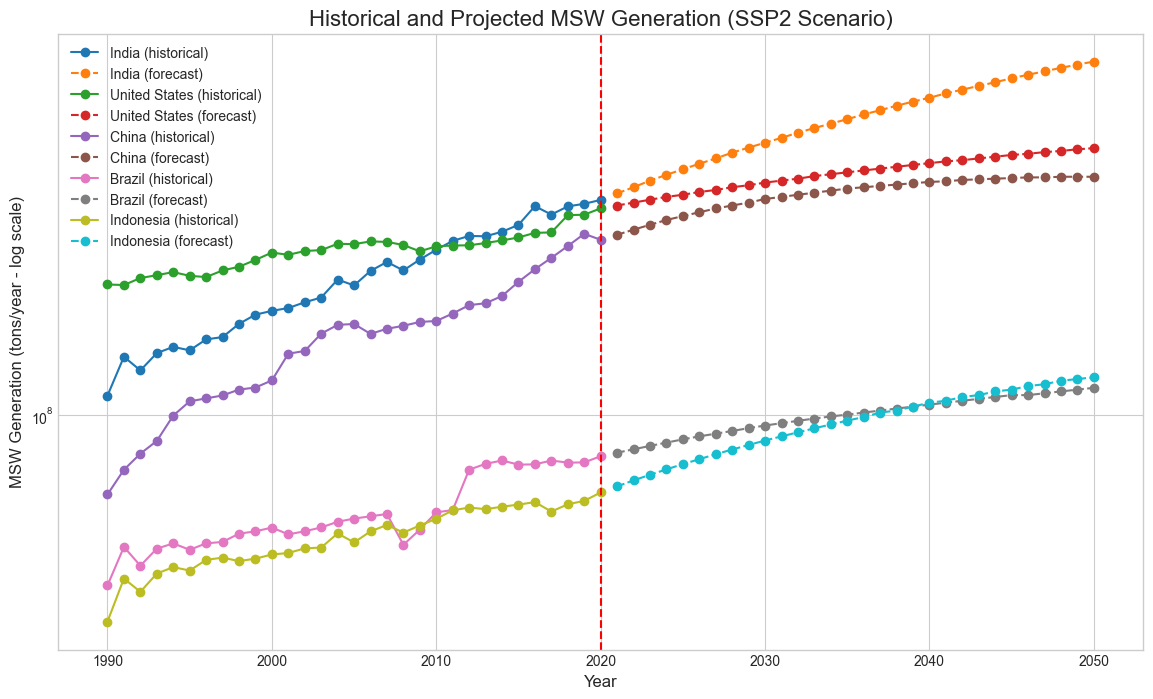

In [8]:
# Define key countries (e.g., top 5 by latest MSW generation)
key_countries = latest_year_df.sort_values('MSW_generation', ascending=False)['Country'].head(5).tolist()

# Prepare forecast data for key countries and SSP2 scenario
forecast_key = forecast_df[
    (forecast_df['Country'].isin(key_countries)) &
    (forecast_df['Scenario'].astype(str).str.upper().fillna('').str.contains('SSP2'))
].copy()

# Ensure correct types
forecast_key['Year'] = pd.to_numeric(forecast_key['Year'], errors='coerce')
forecast_key['MSW_generation'] = pd.to_numeric(forecast_key['MSW_generation'], errors='coerce')

# Drop rows with missing Year or MSW_generation
forecast_key = forecast_key.dropna(subset=['Year', 'MSW_generation'])

# Concatenate historical and forecast data for the selected key countries
trend_df = historical_df[historical_df['Country'].isin(key_countries)].copy()
trend_all = pd.concat([trend_df, forecast_key], ignore_index=True)

# Separate historical and forecast data
historical = trend_all[trend_all['Year'] <= 2020]
forecast = trend_all[trend_all['Year'] > 2020]

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))

for country in key_countries:
    hist = historical[historical['Country'] == country]
    fore = forecast[forecast['Country'] == country]
    plt.plot(hist['Year'], hist['MSW_generation'], marker='o', label=f"{country} (historical)")
    if not fore.empty:
        plt.plot(fore['Year'], fore['MSW_generation'], marker='o', linestyle='--', label=f"{country} (forecast)")

plt.title('Historical and Projected MSW Generation (SSP2 Scenario)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('MSW Generation (tons/year - log scale)', fontsize=12)
plt.yscale('log')
plt.legend()
plt.axvline(x=2020, color='red', linestyle='--', label='Forecast Start')
plt.show()

### Correlation Matrix of Historical Data
A correlation matrix helps us understand the relationships between different numerical variables in our historical dataset. A value close to 1 indicates a strong positive correlation, while a value close to -1 indicates a strong negative correlation.

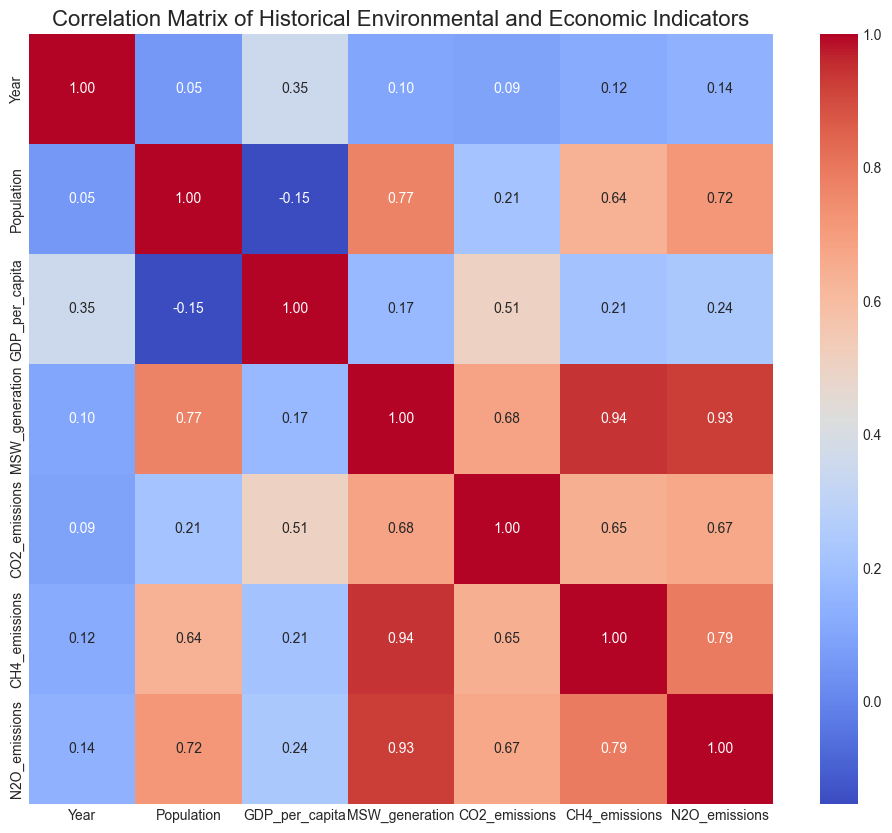

In [9]:
# Select only numeric columns for correlation matrix
numeric_historical_df = historical_df.select_dtypes(include=np.number)

plt.figure(figsize=(12, 10))
correlation_matrix = numeric_historical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Historical Environmental and Economic Indicators', fontsize=16)
plt.show()

## Conclusion
This exploratory data analysis provided a preliminary look into the national-scale environmental pressure indicators dataset. Key takeaways include:

- **Vast Differences in Waste Generation**: The choropleth map illustrated the significant disparity in Municipal Solid Waste (MSW) generation across countries, with larger economies and more populous nations leading.
- **Strong Growth Trends**: Historical and projected data for key countries show a consistent and significant upward trend in waste generation, highlighting a growing environmental challenge.
- **Strong Correlations**: The correlation matrix of the historical data revealed strong positive correlations between MSW generation, greenhouse gas emissions (CO₂, CH₄, N₂O), and economic indicators like GDP and population. This underscores the close link between economic activity, consumption patterns, and environmental impact.

This initial analysis sets the stage for more advanced modeling, such as forecasting future emissions based on various socioeconomic drivers or analyzing the potential for decoupling economic growth from environmental pressures under different future scenarios (SSPs).